In [1]:
# apt-get -y install libgl1-mesa-glx
# apt-get install libglib2.0-0
import os
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
import torch
import random
import torch.nn.functional as F
import re
import math
from diffusers import DPMSolverMultistepScheduler
from models.stablediffusion import StableDiffusionPipeline
from matplotlib import pyplot as plt

# Stable Diffusion Heatmapping

### Model Setting

In [2]:
def auto_device(obj = torch.device('cpu')):
    if isinstance(obj, torch.device):
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        return obj.to('cuda')

    return obj

def set_seed(seed: int) -> torch.Generator:
    random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen = torch.Generator(device=auto_device())
    gen.manual_seed(seed)
    return gen

# Model loading...
model_id = "stabilityai/stable-diffusion-2-1"
# model_id = "CompVis/stable-diffusion-v1-4"


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
net = torch.nn.DataParallel(pipe).to(device)
pipe = net.module
# pipe.unet.config.sample_size = 64

prompt = "a photo of an astronaut riding a horse on mars"
# prompt = "portrait photo of a doctor singing a song"
# prompt = "a male nurse"

print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 7387.34it/s]


Current cuda device: 0
Count of using GPUs: 2


## Exponential Scheduler time steps

In [3]:
# prompt = "A photo of a flying chicken"
# prompt = "A photo of an elephants in the refrigerator"
# prompt = "A photo of a black unicorn"
prompt = "a photo of an astronaut riding a horse on mars"


In [4]:
num_step = 30
semantic_or_delicate = "semantic"
lamda = 60
alpha = math.e ** (math.log(1000)/(num_step+lamda))
if semantic_or_delicate == "semantic":
    time_steps = [1000-int(alpha ** (i+1+lamda))for i in range(num_step)]
    time_steps.insert(0, 999)
    time_steps.pop(-1)
elif semantic_or_delicate == "delicate":
    time_steps = [int(alpha ** (i+1+lamda))for i in range(num_step)]
    time_steps.sort(reverse=True)
    if time_steps[0] == 1000:
        time_steps[0] = 999
else:
    raise ValueError
time_steps = np.array(time_steps)
time_steps = torch.from_numpy(time_steps).to(device)
time_steps

tensor([999, 893, 884, 875, 865, 854, 842, 829, 816, 801, 785, 768, 749, 729,
        708, 684, 659, 632, 602, 571, 536, 499, 459, 416, 370, 319, 265, 206,
        143,  74], device='cuda:0')

lambda changing

In [4]:
inference_steps = 20
visualization_step = 15
seed_num = 1
torch.cuda.empty_cache()
all_generated_images, heatmap, output, auc_score  = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type ='pil',
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "lime", 'mask' : "gaussian", 'layer_vis' : False},
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
# semantic_or_delicate = "original"


# img_name = prompt.split("A photo of")[-1]
# output.images[0].save(os.path.join("outputs/lambda", f"{img_name}_{lamda}_{semantic_or_delicate}.png"))

Perturbing and decoding..: 100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


(1000, 8)
(1000, 9216)
(9216,)


In [12]:
auc_score_min, auc_score_max = auc_score.min(), auc_score.max()
# normalization
auc_score2 = (auc_score - auc_score_min) / (auc_score_max - auc_score_min)

In [13]:
auc_score2

array([0.86936763, 0.92316307, 0.9441126 , 0.96088951, 0.90033794,
       1.        , 0.97737793, 0.92023785, 0.93916325, 0.93034494,
       0.90896763, 0.87301217, 0.83479783, 0.84842663, 0.8688857 ,
       0.85929628, 0.88445261, 0.84384621, 0.8511072 , 0.83014472,
       0.81691477, 0.85585135, 0.85273993, 0.8519577 , 0.81329732,
       0.825549  , 0.83401139, 0.83207382, 0.82349144, 0.81066869,
       0.80965575, 0.80023215, 0.77595518, 0.77409779, 0.7804763 ,
       0.77052561, 0.7500593 , 0.75137167, 0.72384841, 0.72311593,
       0.72869263, 0.70131696, 0.72055381, 0.69910964, 0.71091919,
       0.74789298, 0.73344535, 0.75152453, 0.76435612, 0.77414336,
       0.75990483, 0.70544372, 0.72615966, 0.72575364, 0.70281362,
       0.69600947, 0.70779039, 0.64162991, 0.62763029, 0.63511037,
       0.58690934, 0.58086328, 0.57315981, 0.5710173 , 0.54096795,
       0.55171841, 0.49644989, 0.49805618, 0.4238281 , 0.42884056,
       0.3814833 , 0.39406391, 0.38564892, 0.37172481, 0.37952

In [9]:
def normal_auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

In [14]:
normal_auc(auc_score2)

0.619138768383233

In [26]:
img = np.array(all_generated_images[-1][0])
img.shape

(512, 512, 3)

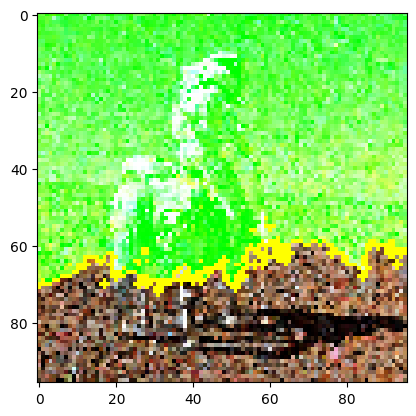

In [5]:
from skimage.segmentation import mark_boundaries
img_boundry2 = mark_boundaries(heatmap[0], heatmap[1])
plt.imshow(img_boundry2)

In [8]:
a = torchnp.array([1,2]).cuda()
a

AttributeError: 'numpy.ndarray' object has no attribute 'cuda'

Only image generation

In [5]:
inference_steps = 5
visualization_step = 5
seed_num = 1
torch.cuda.empty_cache()
output,_,_,  = pipe(
    prompt,
    num_inference_steps=num_step,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type ='pil',
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = time_steps,
    )
# semantic_or_delicate = "original"


img_name = prompt.split("A photo of")[-1]
output.images[0].save(os.path.join("outputs/sampling_output", f"{img_name}_{semantic_or_delicate}.png"))
# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))
# plt.imshow(org_img.permute(1, 2, 0))
# plt.axis("off")

# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()
# torch.cuda.empty_cache()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/sampling_output/ a black unicorn_delicate.png'

In [ ]:
inference_steps = 20
visualization_step = 18
num_masks = 500
seed_num = 1
torch.cuda.empty_cache()
all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = time_steps,
    )
save = True
save_pth = f"./outputs/rise/ssim/v1.5/horse_austro_seed1"
if not os.path.exists(save_pth):
    os.mkdir(save_pth)

img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
# original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * prev_noise + (mask_sqz ** 0.8) * heatmap
original_cam = 1 * (1 - mask_sqz ** 0.8) * prev_noise + (mask_sqz ** 0.8) * heatmap
# original_cam = heatmap + prev_noise
original_gradcam = original_cam.cpu().detach().squeeze(0)
# Visualization
plt.figure('Diffusion RISE', figsize=(10,4))

# plt.subplot(1,4,1)
# plt.imshow(original_gradcam.permute(1, 2, 0))
# plt.axis("off")

plt.subplot(1,3,1)
plt.imshow(org_img.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(org_img.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(post_noise.permute(1, 2, 0))
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
plt.show()
torch.cuda.empty_cache()

### Diffusion RISE

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


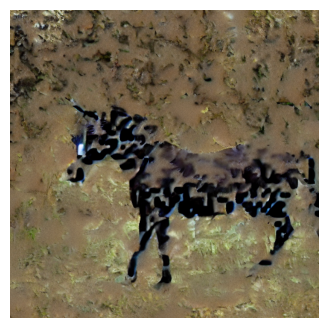

In [4]:
inference_steps = 20
visualization_step = 20
num_masks = 30
seed_num = 1

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
# save = True
# save_pth = f"./outputs/rise/ssim/v1.5/horse_austro_seed1"
# if not os.path.exists(save_pth):
#     os.mkdir(save_pth)

# img_size = all_images[0].shape[1]

# saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
# saliency = saliency_map.clone()
# # Upsampling
# saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

# saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# # normalization
# saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

# mask = saliency_map.cpu().data
# mask = (mask - mask.min()).div(mask.max() - mask.min()).data
# heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
# heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
# heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# mask_sqz = mask.squeeze(0)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
# original_gradcam = original_cam.cpu().detach().squeeze(0)

# prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
# post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))

# plt.subplot(1,4,1)
# plt.imshow(prev_noise.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,2)
# plt.imshow(heatmap.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,3)
# plt.imshow(original_cam.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,4)
# plt.imshow(post_noise.permute(1, 2, 0))
# plt.axis("off")
# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()


In [3]:
inference_steps = 20
visualization_step = 20
num_masks = 2
seed_num = 1

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
# save = True
# save_pth = f"./outputs/rise/ssim/v1.5/horse_austro_seed1"
# if not os.path.exists(save_pth):
#     os.mkdir(save_pth)

# img_size = all_images[0].shape[1]

# saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
# saliency = saliency_map.clone()
# # Upsampling
# saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

# saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# # normalization
# saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

# mask = saliency_map.cpu().data
# mask = (mask - mask.min()).div(mask.max() - mask.min()).data
# heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
# heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
# heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# mask_sqz = mask.squeeze(0)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
# original_gradcam = original_cam.cpu().detach().squeeze(0)

# prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
# post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))

# plt.subplot(1,4,1)
# plt.imshow(prev_noise.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,2)
# plt.imshow(heatmap.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,3)
# plt.imshow(original_cam.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,4)
# plt.imshow(post_noise.permute(1, 2, 0))
# plt.axis("off")
# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()


(1, 512, 512, 3)


RuntimeError: number of dims don't match in permute

<Figure size 1000x400 with 0 Axes>

FIgure for step visualization

In [ ]:
inference_steps = 20
visualization_step = 1
seed_num = 0
torch.cuda.empty_cache()
output,_,_,  = pipe(
    prompt,
    num_inference_steps=num_step,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type ='pil',
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
semantic_or_delicate = "original"


img_name = prompt.split("A photo of")[-1]
output.images[0].save(os.path.join("outputs/sampling_output", f"{img_name}_{semantic_or_delicate}.png"))
# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))
# plt.imshow(org_img.permute(1, 2, 0))
# plt.axis("off")

# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()
# torch.cuda.empty_cache()

In [ ]:
def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

In [ ]:
auc(auc_score)

# Evaluation by segmentation